# Sample Molecular Dynamics (MD) simulation code for LJ particle
## Velocity Verlet  + temperature control by velocity scaling or Nose-Hoover
2018, 2019, May, Tsuyoshi Okubo  
2021, May, modified by Tsuyoshi Okubo  
2022, May, modified intial condition by Tsuyoshi Okubo


In this notebook, you can simulate dynamics of LJ particles in three-dimensional spcae with or without temperature control. Without temperature control, the total Hamiltoninan
$$ H =  \sum_{i} \frac{p_i^2}{2m_i} +\sum_{i} U(q_i)$$
is expected to be conserved. Here, 
* $q_i$ and $p_i$ : are coodinate and momentum, respectively.
In contrast, with temperature control, there is no conserved quantities. (Nose-Hoover is not a symplectec integrator for any Hamiltonians.)

We first use NVT simulation with Nose-Hoover thermostad. Then we perform NVE simulation or NVT simulation to investigate the equilibrium dynamics. 


You can change physical conditions:
* **N** : the number of particles
* **rho** : the initical density
* **T_set** : desired temperature (used only simulations with temperature control)

For simulation parameter you can set
* **dt** : time step for integral
* **thermalization**: integral time steps for thermalizaiton. Within this step, we use Nose-Hoover thermostad to control the temperature as T_set. Total thermalization time is dt * thermalization.
* **observation**: integral time steps for overservation. After thermalization, we perform NVE or NVT simulation, depending on the obs_temperature_control flag, with this step. Total observation time is dt * observation.
* **output_step**: physical quantities are observed with this interval, both for the thermalization and the observation.


For temperature control
* **use_Nose_Hoover**: flag for using Nose-Hoover thermostad
* **Nose_tau**: characteristic time scall for Nose-Hoover thermostad. For details, please see the lecture slide.
* **use_velocity_scaling**: flag for using velosity scaling

For auto correlation functions
* **correlation_step**: The longest time (MD steps) for plotting the auto-correlation fuctions.
    * In order to obtain more accurate auto correlation fuctions, you may need to increase total simulation time.

Ref. 奥村久士, 「分子動力学シミュレーションにおける温度・圧力制御」、分子シミュレーション研究会会誌 “アンサンブル” (2008, 2009).


In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from numba import jit ## for speed up, we use jit compile

In [2]:
## parameters for system
N=200 # number of particles
rho = 0.3 #number density
T_set = 2.0 # temperature if Nose-Hoober or velocity_scaling is used

## parameters for integration
dt = 0.01 ## for higer temperature, dt must be shorter
thermalization = 5000
observation = 5000
output_step = 1

## algorithm
use_Nose_Hoover = False #True
Nose_tau = 0.1
use_velocity_scaling = False #True

## parameter for auto correlation
correlation_step = 100

In [3]:
## initialization of parameter
L = (N/rho)**(1.0/3.0)

In [4]:
@jit(nopython = True)
def periodic_boundary(x,L):
    if np.abs(x) > L*0.5:
        x -= np.sign(x)*L
    return x

@jit(nopython = True)
def periodic_boundary_all(x,L):
    for i in range(N):
        x[i] = periodic_boundary(x[i],L)
    return x
@jit(nopython = True)
def force_lj(rx,ry,rz,L,r2_cut=2.5**2):
    ## calculate force, energy and virial for the LJ potential
    r2_inv = 1.0/r2_cut
    r6_inv = r2_inv**3
    pot_base = 4.0 * r6_inv * (r6_inv - 1.0)

    fx = np.zeros(N)
    fy = np.zeros(N)
    fz = np.zeros(N)
    Ep = 0.0
    virial = 0.0
    for i in range(N):
        for j in range(i+1,N):
            xij = periodic_boundary(rx[i]-rx[j],L)
            yij = periodic_boundary(ry[i]-ry[j],L)
            zij = periodic_boundary(rz[i]-rz[j],L)
            r2 = xij**2 + yij**2 + zij**2
            if r2 < r2_cut:
                r2_inv = 1.0/r2
                r6_inv = r2_inv**3
                
                f_factor = 48.0 * r6_inv * (r6_inv - 0.5)/r2
                fxi = f_factor * xij
                fyi = f_factor * yij
                fzi = f_factor * zij

                fx[i] += fxi
                fy[i] += fyi
                fz[i] += fzi

                fx[j] -= fxi
                fy[j] -= fyi
                fz[j] -= fzi

                Ep += 4.0 * r6_inv * (r6_inv - 1.0) - pot_base
                virial += fxi * xij + fyi * yij + fzi * zij
                
    
    Ep /= N
    return fx,fy,fz,Ep,virial

In [5]:
@jit(nopython = True)
def Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L):
    dt2 = dt * 0.5
    ## v: t + dt/2, r: t+dt
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    rx += px * dt
    ry += py * dt
    rz += pz * dt

    rx = periodic_boundary_all(rx,L)
    ry = periodic_boundary_all(ry,L)
    rz = periodic_boundary_all(rz,L)
    fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

    ## v: t + dt/2 + dt/2
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
    
    return rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial

In [6]:
@jit(nopython = True)
def Velocity_Verlet_Nose(rx,ry,rz,px,py,pz,fx,fy,fz,zeta,dt,L,T_set,Nose_tau):
    dt2 = dt * 0.5
    exp_zeta = np.exp(-zeta*dt2)

    px *= exp_zeta
    py *= exp_zeta
    pz *= exp_zeta
    ## v: t + dt/2, r: t+dt
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    rx += px * dt
    ry += py * dt
    rz += pz * dt

    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
    zeta += (2.0*Ek/3.0 - T_set)/Nose_tau**2 * dt
        
    rx = periodic_boundary_all(rx,L)
    ry = periodic_boundary_all(ry,L)
    rz = periodic_boundary_all(rz,L)
    fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

    ## v: t + dt/2 + dt/2
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    exp_zeta = np.exp(-zeta*dt2)
    px *= exp_zeta
    py *= exp_zeta
    pz *= exp_zeta
    
    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
    
    return rx,ry,rz,px,py,pz,fx,fy,fz,zeta,Ep,Ek,virial

In [7]:
## initialization of variables
## simple cubic
rx = np.zeros(N)
ry = np.zeros(N)
rz = np.zeros(N)

px = np.zeros(N)
py = np.zeros(N)
pz = np.zeros(N)


l = N**(1.0/3.0)
nl = int(np.floor(l))+1
d = L/nl

ix = np.zeros(N,dtype=int)
iy = np.zeros(N,dtype=int)
iz = np.zeros(N,dtype=int)
for i in range(N):
    iz[i] = i/nl**2
    iy[i] = (i-iz[i] * nl**2)/nl
    ix[i] = i%nl
rx = -0.5 * L + d * ix + 0.5
ry = -0.5 * L + d * iy + 0.5
rz = -0.5 * L + d * iz + 0.5

rx = periodic_boundary_all(rx,L)
ry = periodic_boundary_all(ry,L)
rz = periodic_boundary_all(rz,L)

fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)


## short time relaxation
for i in range(100):
    rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial = Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L)

Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
Pressure = (2.0 * N * Ek + virial)/(3.0*L**3)
H0 = Ep + Ek

Ep_dyn = [Ep]
Ek_dyn = [Ek]
Pressure_dyn = [Pressure]

## variables for Temeperature
zeta = 0.0
zeta_dyn = [zeta]

In [8]:
%%time
## main simulation part
for i in range(thermalization+observation):
    if i < thermalization or use_Nose_Hoover: 
        rx,ry,rz,px,py,pz,fx,fy,fz,zeta,Ep,Ek,virial = Velocity_Verlet_Nose(rx,ry,rz,px,py,pz,fx,fy,fz,zeta,dt,L,T_set,Nose_tau)
    else: 
        rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial = Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L)
    
        if use_velocity_scaling:
            vfactor =np.sqrt(T_set/(Ek*2.0/3.0))
            px *= vfactor
            py *= vfactor
            pz *= vfactor
            Ek *= vfactor**2

    if i % output_step == 0:
        Pressure = (2.0 * N * Ek + virial)/(3.0*L**3)

        Ep_dyn.append(Ep)
        Ek_dyn.append(Ek)
        Pressure_dyn.append(Pressure)

        ## variables for Temeperature
        zeta_dyn.append(zeta)


CPU times: user 4.36 s, sys: 30.1 ms, total: 4.4 s
Wall time: 4.42 s


## Physical quantities

In the followings, you can see dynamics of physicsal quantities.

Note that after initial "turbulence", energy, temperature and pressure become almost constant, which indicate the system is in equilibrium. With temperature controls, you can see the temperature is correctly controlled to the T_set.

In adittion, without temperature control, the energy is stable without any drift behaviors.


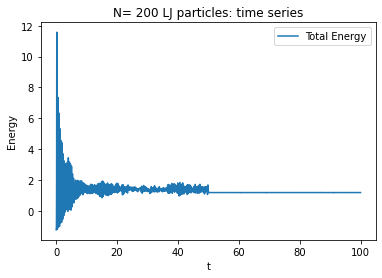

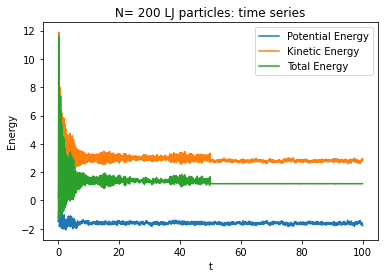

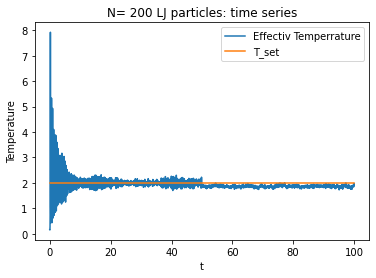

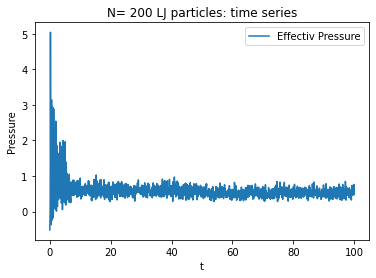

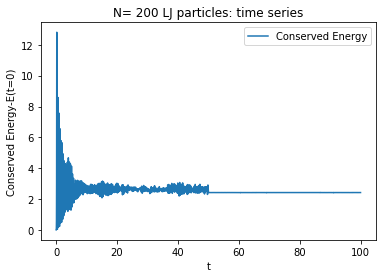

In [9]:
## plot time series
Ep = np.array(Ep_dyn)
Ek = np.array(Ek_dyn)
Pressure = np.array(Pressure_dyn)

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(Ek.size)*dt*output_step,Ek+Ep,label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(Ep.size)*dt*output_step,Ep,label="Potential Energy")
pyplot.plot(np.arange(Ek.size)*dt*output_step,Ek,label="Kinetic Energy")
pyplot.plot(np.arange(Ek.size)*dt*output_step,Ek+Ep,label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Temperature")
pyplot.plot(np.arange(Ek.size)*dt*output_step,2.0*Ek/3.0,label="Effectiv Temperrature")
pyplot.plot([0, Ep.size*dt*output_step], [T_set, T_set],label="T_set")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Pressure")
pyplot.plot(np.arange(Pressure.size)*dt*output_step,Pressure,label="Effectiv Pressure")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Conserved Energy-E(t=0)")
pyplot.plot(np.arange(Ep.size)*dt*output_step,Ek+Ep-H0,label="Conserved Energy")
pyplot.legend()




pyplot.show()





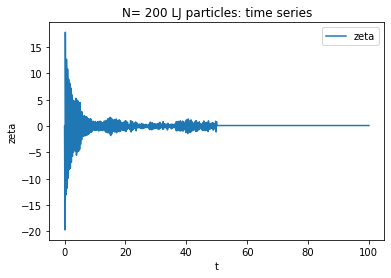

In [10]:
## plot thermostad variable
zeta = np.array(zeta_dyn)

pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("zeta")
pyplot.plot(np.arange(zeta.size)*dt*output_step,zeta,label="zeta")
pyplot.legend()
pyplot.show()



In the followings, you can see dynamics of physicsal quantities **after the thermalization**.


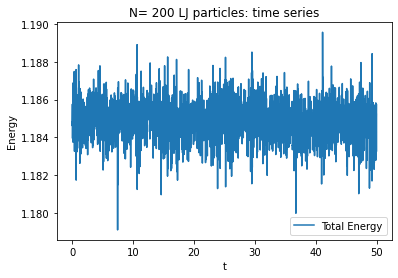

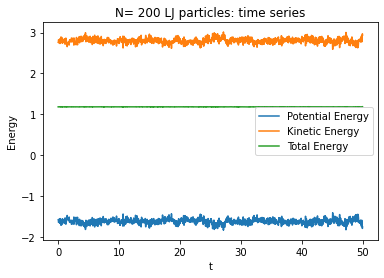

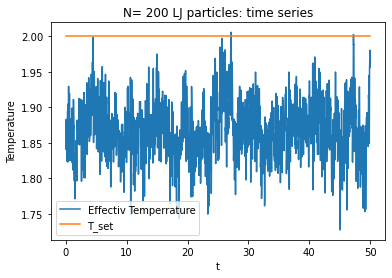

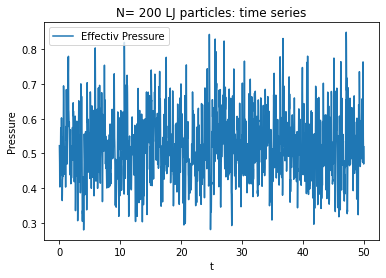

In [14]:
thermal_step = thermalization // output_step
observ_step = observation // output_step

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,(Ek+Ep)[thermal_step+1:],label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,Ep[thermal_step+1:],label="Potential Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,Ek[thermal_step+1:],label="Kinetic Energy")
pyplot.plot(np.arange(observ_step)*dt*output_step,(Ek+Ep)[thermal_step+1:],label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Temperature")
pyplot.plot(np.arange(observ_step)*dt*output_step,2.0*Ek[thermal_step+1:]/3.0,label="Effectiv Temperrature")
pyplot.plot([0, observ_step*dt*output_step], [T_set, T_set],label="T_set")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Pressure")
pyplot.plot(np.arange(observ_step)*dt*output_step,Pressure[thermal_step+1:],label="Effectiv Pressure")
pyplot.legend()


pyplot.show()

## Auto correlation function

In the followings, you can see the auto correlation function of the potential energy, the temperature, and the pressure. 

Here we discard the first themalizatoin steps and use remeining observation steps for the analysis.

In addition, the integrated auto-correlation times will be caluculated.


Average temperature = 1.8696826501370334
Average pressure = 0.5195942087452747


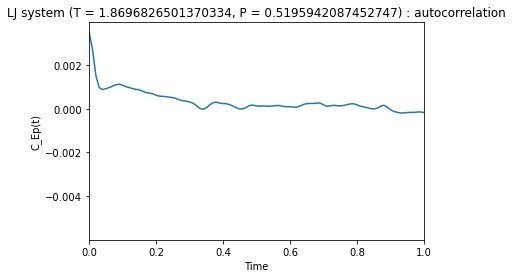

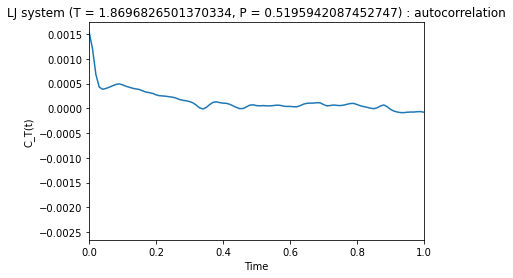

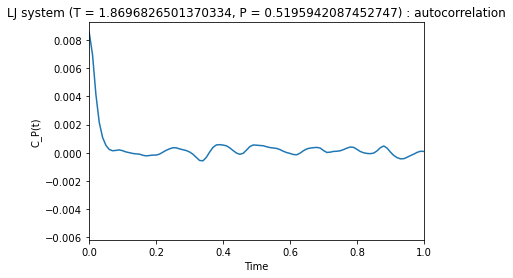

In [12]:
Ep_fluct = Ep[thermal_step+1:] - Ep[thermal_step+1:].mean()
T_fluct = (Ek[thermal_step+1:]- Ek[thermal_step+1:].mean()) * 2.0/3.0
P_fluct = Pressure[thermal_step+1:] - Pressure[thermal_step+1:].mean()

ave_T = Ek[thermal_step+1:].mean() * 2.0 / 3.0
ave_P = Pressure[thermal_step+1:].mean()
print("Average temperature = "+repr(ave_T))
print("Average pressure = "+repr(ave_P))

cor_Ep = np.correlate(Ep_fluct,Ep_fluct,mode="full")
cor_Ep = cor_Ep[cor_Ep.size//2:]/np.arange(Ep_fluct.size,0,-1)
cor_T = np.correlate(T_fluct,T_fluct,mode="full")
cor_T = cor_T[cor_T.size//2:]/np.arange(T_fluct.size,0,-1)
cor_P = np.correlate(P_fluct,P_fluct,mode="full")
cor_P = cor_P[cor_P.size//2:]/np.arange(P_fluct.size,0,-1)

pyplot.figure()
pyplot.title("LJ system (T = "+repr(ave_T) +", P = "+repr(ave_P) +") :"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_Ep(t)")
pyplot.plot(np.arange(cor_Ep.size)*dt,cor_Ep)
pyplot.xlim([0,correlation_step*dt])

pyplot.figure()
pyplot.title("LJ system (T = "+repr(ave_T) +", P = "+repr(ave_P) +") :"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_T(t)")
pyplot.plot(np.arange(cor_T.size)*dt,cor_T)
pyplot.xlim([0,correlation_step*dt])

pyplot.figure()
pyplot.title("LJ system (T = "+repr(ave_T) +", P = "+repr(ave_P) +") :"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_P(t)")
pyplot.plot(np.arange(cor_P.size)*dt,cor_P)
pyplot.xlim([0,correlation_step*dt])

pyplot.show()

In [13]:
## output integrated correlation time
print("Tau potential energy = " + repr(np.sum(cor_Ep[:correlation_step//output_step])/cor_Ep[0]*dt*output_step))
print("Tau temperature = " + repr(np.sum(cor_T[:correlation_step//output_step])/cor_T[0]*dt*output_step))
print("Tau pressure = " + repr(np.sum(cor_P[:correlation_step//output_step])/cor_P[0]*dt*output_step))

Tau potential energy = 0.1781130478174673
Tau temperature = 0.17993763230544033
Tau pressure = 0.06347947187695514
